In [22]:
import os
os.chdir('/Users/tud500158/Documents/github/AutomatedDamageDetection/scripts/train-vae/')

import numpy as np
import tensorflow as tf
import glob
import geopandas as gpd
import json
import configparser 
from sklearn.manifold import TSNE
import rioxarray as rioxr
import xarray as xr
import os

import dataset
import tiles as ts

# from shapely import geometry
from rasterio.features import shapes, geometry_mask
import pathlib
import pandas as pd
import xarray as xr

print('---- modules imported')
os.chdir('/Users/tud500158/Documents/github/AutomatedDamageDetection/')


---- modules imported


In [76]:

def parse_config(config):
    """ Parse input arguments from dictionary or config file """
    if not isinstance(config, dict):
        parser = configparser.ConfigParser()
        parser.read(config)
        config = parser["train-VAE"]

    catPath = config['catalogPath']
    labPath = config['labelsPath']
    outputDir = config['outputDirectory']
    sizeTestSet = int(config['sizeTestSet'])
    sizeValSet = int(config['sizeValidationSet'])
    roiFile = config['ROIFile']
    bands = [int(i) for i in config['bands'].split(" ")]
    sizeCutOut = int(config['sizeCutOut'])
    nEpochMax = int(config['nEpochMax'])
    sizeStep = int(config['sizeStep'])
    normThreshold = float(config['normalizationThreshold'])
        
    return (catPath, labPath, outputDir, sizeTestSet, sizeValSet, roiFile,
            bands, sizeCutOut, nEpochMax, sizeStep, normThreshold)




In [104]:

# path_to_traindir = './model_v0/train_epoch_2/' # path on local computer
path_to_traindir = os.path.join(os.getcwd(), 'training','2022-05') # path on local computer
# path_to_traindir = './train/model_v0/train_epoch_2/' # path on cartesius
ini_file = 'train-vae_balance_000.ini'
model_dir = 'model_1651676774'


# parse input arguments
config = glob.glob(os.path.join(path_to_traindir,model_dir, ini_file))
catalog_path, labels_path, outputDir, sizeTestSet, sizeValSet, roiFile, bands, \
    cutout_size, nEpochmax, sizeStep, normThreshold = parse_config(config)

# local maachine: overwrite caatalogpath and labelspath
catalog_path = '/Users/tud500158/Documents/Data/tiles'
labels_path ='/Users/tud500158/Documents/PhD/crevasseDetection/GoogleEarth/labels/geojson/EPSG4326/'

In [79]:
os.path.join(path_to_traindir , 'model*')
glob.glob(os.path.join(path_to_traindir , model_dir))
# path_to_traindir

['/Users/tud500158/Documents/github/AutomatedDamageDetection/training/2022-05/model_1651676774']

In [80]:

''' ----------
Load model
------------'''


path_to_model = glob.glob(os.path.join(path_to_traindir , model_dir))
print(path_to_model)
path_to_model = path_to_model[0]
epoch_dirs = glob.glob(path_to_model +'/epoch*' )
encoder_dirs = glob.glob(path_to_model+'/encoder*')
path_to_model_epoch = epoch_dirs[-1]
path_to_encoder_epoch = encoder_dirs[-1]


model = tf.keras.models.load_model(path_to_model_epoch ,compile=False)
encoder = tf.keras.models.load_model(path_to_encoder_epoch,compile=False)

# Get latent_dim (of sampling layer)
latent_dim = encoder.layers[-1].output_shape[-1] # is 4


print('---- loaded model, encoder and .ini')


['/Users/tud500158/Documents/github/AutomatedDamageDetection/training/2022-05/model_1651676774']
---- loaded model, encoder and .ini


In [81]:
# os.path.join(path_to_traindir , model_dir, 'datasets*.json')

In [148]:


''' ----------
Get testdata: one tile

Instead of loading tiles directly as tf Dataset with dataset.Dataset(), load the tile as xarray to be able to link it to labels
------------'''

# get info on which tiles are assigned as test tiles
datasets_json = glob.glob(os.path.join(path_to_traindir, model_dir , 'datasets*.json'))

with open(datasets_json[0]) as file:        # Opening JSON file
    datasets_dict = json.loads(file.read()) # load data

test_set_paths = datasets_dict['test']   
test_set_paths

# test: 1 tile
# num_tiles = 1 # number of tiles to load
# tile_list = test_set_paths[:num_tiles];
# print('tilelist: ' , tile_list)

tile_list = test_set_paths

# update tile_list to be for local machine
tile_names = [tile_n.split('/')[-1] for tile_n in tile_list]
tile_path_local = pathlib.Path('/Users/tud500158/Documents/Data/tiles/')
tile_list_local = [os.path.join(tile_path_local,tile_name) for tile_name in tile_names]

# tiles that are actually on my local machine
tiles_on_machine = glob.glob(os.path.join(tile_path_local , '*.tif'))

# remake tile_list 
tile_list = []
for tile in tiles_on_machine:
    if tile in tile_list_local:
        tile_list.append(actual_file)

In [150]:
tile_list

['/Users/tud500158/Documents/Data/tiles/S2_composite_2019-11-1_2020-3-1_tile_124.tif']

In [151]:
# # tile_list = []
# for tile in tile_list_local:
#     if tile not in tiles_on_machine:
#         tile_list.remove(tile)
# tile_list        

['/Users/tud500158/Documents/Data/tiles/S2_composite_2019-11-1_2020-3-1_tile_124.tif']


['/Users/tud500158/Documents/Data/tiles/S2_composite_2019-11-1_2020-3-1_tile_124.tif']

In [109]:
# labels_path = pathlib.Path(labels_path)
# os.listdir(labels_path)

In [108]:


''' ----------
Get Labels
------------'''


# # read tile catalog to be able to get CRS and filter labels to same date
catalog = ts._read_tile_catalog(catalog_path)
tiles = ts._catalog_to_geodataframe(catalog)

labels = ts._read_labels(labels_path, verbose=True)
labels = labels.to_crs(tiles.crs)  # make sure same CRS is used
# select the only labels matching the tiles timespan
labels = ts._filter_labels(labels,
                        tiles.start_datetime.min(),
                        tiles.end_datetime.max())


## Create GeoSeries from labels.geometry
label_polys = gpd.GeoSeries(labels.geometry,crs=labels.crs) # Combine all geometries to one GeoSeries, with the 


Labels successfully read from 16 files
Selecting 627 out of 905 labels


In [180]:

''' ----------
Create cut-outs
    Actually read the tile, make cutouts, linked with labeldata
------------'''


for tile in tile_list: # from dataset.py _generate_cutouts
    # get tile name
    tileName = tile.split("/")[-1][:-4] # vb: 'S2_composite_2019-11-1_2020-3-1_tile_124'
    print('\n----\n Processing ' + tileName +'\n')
    
    # read tile - floats are required to mask with NaN's
    da = rioxr.open_rasterio(tile).astype("float32")

    # select bands
    if bands is not None:
        if type(bands) is not list:
            da = da.sel(band=[bands])
        else:
            da = da.sel(band=bands)

    # mask/clip: if self.mask is not None: [removed; see _generate_cutouts]

    # apply offset [removed: only relevant for training, not for testing]
    
    # rasterize labels: create mask on tile raster
    labels_tileraster = geometry_mask(label_polys,
                                      out_shape=(len(da.y),len(da.x)),
                                      transform=da.rio.transform(),invert=True)
    labels_tileraster = labels_tileraster.astype(np.dtype('uint16')) # np ndarray (x , y)
    labels_tileraster = np.expand_dims(labels_tileraster,axis=0) # ndarray (1 , x , y) because tiledata shape (3,x,y)
    # create dataArray from np ndarray
    da_label = xr.DataArray(
                data=labels_tileraster,
                dims=["band","x", "y"])
    

    # generate windows
    da = da.rolling(x=cutout_size, y=cutout_size)
    da = da.construct({'x': 'x_win', 'y': 'y_win'}, stride=cutout_size)

    # drop NaN-containing windows
    da = da.stack(sample=('x', 'y'))
    da = da.dropna(dim='sample', how='any')

    # normalize
    if normThreshold is not None:
        da = (da + 0.1) / (normThreshold + 1)
        da = da.clip(max=1)

    tile_cutouts = da.data.transpose(3, 1, 2, 0) # samples, x_win, y_win, bands: (250000, 20, 20, 3)
    
    # same for labels:
    da_label = da_label.rolling(x=cutout_size, y=cutout_size)
    da_label = da_label.construct({'x': 'x_win', 'y': 'y_win'}, stride=cutout_size)
    da_label = da_label.stack(sample=('x', 'y'))
    da_label = da_label.dropna(dim='sample', how='any')
    # no need to normalize
    label_cutouts = da_label.data.transpose(3, 1, 2, 0)  # samples, x_win, y_win, bands: (250000, 20, 20, 1)


    print(tile_cutouts.shape , label_cutouts.shape)



    ''' ----------
    Encode input 
    ------------'''


    # encoded_data,_,_ = encoder.predict(test_set_tf);
    encoded_data,_,_ = encoder.predict(tile_cutouts);
    np.save(tileName + "_encoded.npy", encoded_data) # save encoded data for later use.
    np.save(tileName + "_labels.npy", label_cutouts) # save encoded data for later use.
    print('---- succesfully encoded data; size: ', encoded_data.shape)


    # predicted_data = model.predict(test_set_tf); # reconstruct images (windows):
    predicted_data = model.predict(tile_cutouts); # reconstruct images (windows):
    np.save(tileName + "_predicted.npy",predicted_data)
    print('---- succesfully predicted data')




----
 Processing S2_composite_2019-11-1_2020-3-1_tile_124

(390625, 20, 20, 3) (390625, 20, 20, 1)
---- succesfully encoded data; size:  (390625, 2)
---- succesfully predicted data


In [181]:

def embed_latentspace_2D(encoded_data,
                         latent_dim,perplexity=10, 
                         n_iter=1000,
                         n_iter_without_progress=300):
    ''' Consider using perplexity between 5 and 50 (default 30); larger datasets usually require a larger perplexity.
        n_iter default 1000, should be at least 250
        learning_rate: the learning rate for t-SNE is usually in the range [10.0, 1000.0], default=200; The ‘auto’ option sets the learning_rate to max(N / early_exaggeration / 4, 50)
    '''
    
    if latent_dim > 2: # only embed if latent_dim is higher than 2D (otherwise plot 2D)
        z_mean_2D = TSNE(n_components=2,
                         perplexity=perplexity,
                         n_iter=n_iter,
                         learning_rate='auto',
                         init='pca',
                         n_iter_without_progress=n_iter_without_progress).fit_transform(encoded_data);
    else: # no embedding needed
        z_mean_2D = encoded_data  # TO DO: check if this outputs the same shape as the embedded z_mean_2D
        
    return z_mean_2D

Nsamples = encoded_data.shape[0] #100000 
# encoded_2D_testdata = embed_latentspace_2D(encoded_data, # sample selection
#                                            latent_dim,perplexity=40,
#                                            n_iter=250,
#                                            n_iter_without_progress=100)

encoded_2D_testdata = encoded_data
# np.save("embedded_data_N{:d}_tileX.npy".format(Nsamples),reconstructed_window)
# z_mean_2D = TSNE(n_components=2,
#                  perplexity=30,
#                  n_iter=250,
#                  init='pca',
#                  n_iter_without_progress=100,
#                  n_jobs=4).fit_transform(encoded_data);
# np.save("embedded_data_N_tileX.npy",encoded_2D_testdata)
print('---- succesfully embedded data to 2D')
 

    
print('\n')

---- succesfully embedded data to 2D




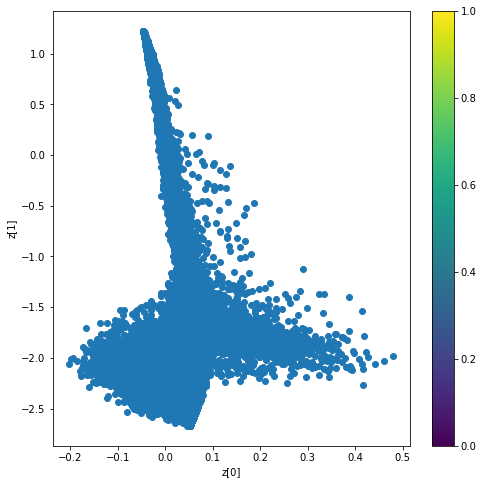

In [165]:
import matplotlib.pyplot as plt

''' ----------
Plot clustering
------------'''
  
    

def plot_latentspace_clusters_no_labels( embedded_data ):#,labels):
    ''' Embedded data should have (N,2)'''
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(embedded_data[:, 0], embedded_data[:, 1])#, c=labels,s=2,cmap='winter') # also add size for scatter point
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()
    return fig
    


fig = plot_latentspace_clusters_no_labels( encoded_2D_testdata )
fig.savefig('embedded_testdata_nolabels_tileX')



781250


IndexError: index 1 is out of bounds for axis 1 with size 1

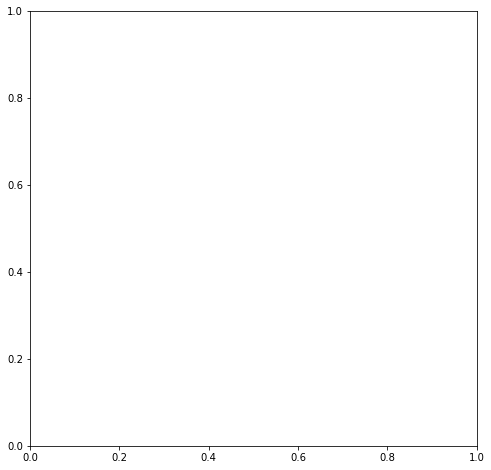

In [189]:

    
def plot_latentspace_clusters( embedded_data,labels ):    
    marksize = 1
    print(embedded_data.size)
    embedded_data = embedded_data[np.argsort(labels)]#,np.argsort(labels)]
    fig, ax1 = plt.subplots(figsize=(8,8) )
    s1 = ax1.scatter(embedded_data[:, 0], embedded_data[:, 1], c=labels, s=marksize, cmap='winter',vmin=0, vmax=1) # also add size for scatter point
    ax1.set_xlabel("z[0]"); 
    ax1.set_ylabel("z[1]");
    fig.colorbar(s1,ax=ax1); 
    return fig

test_data_labels = label_cutouts.sum(axis=1).sum(axis=1) # (Nsamples, 20, 20, 1) to (Nsamples,1)
fig = plot_latentspace_clusters( encoded_2D_testdata , test_data_labels )
    

In [187]:
label_cutouts.sum(axis=1).sum(axis=1)
encoded_2D_testdata.shape
test_data_labels.shape


(390625, 1)

In [171]:
encoded_2D_testdata.shape

(390625, 2)

In [188]:

encoded_2D_testdata[np.argsort(test_data_labels),np.argsort(test_data_labels)].shape

(390625, 1)